# Combining different models for ensemble learning
En capitulos anteriores, nos centramos en las mejores practicas para tunear y evaluar diferentes modelos para clasificacion. En este capitulo, contruiremos sobre esas tecnicas y exploraremos diferentes metodos para construir uun set de clasificadores que en general tendran un mejor poder predictivo que culaquiera de sus partes individuales. En este capitulo veremos:
- Como hacer predicciones por mayoria de voto
- Usar baggin para reudcir el overfitting al tomar combinaciones randoms del dataset de entrenamiento con repeticion
- Aplicar boostin para contruir poderosos modelos a partir from weak learners que aprenden de sus erroes

## Learning with ensembles
El objetivo de los metodos de ensamble es combinar diferntes clasificadores en un meta-clasificador que tiene mejor poder de generalizacion que cualquiera de sus partes individuales. Por ejemplo, asumiendo que recolctamos prediccioens de 10 expertos, los metodos de ensamble nos permitiria  combinar de manera estrategia esas 10 predicciones para realizar una prediccion mas robusta que la prediccion original. Hay diferentes metodos para crear estos ensambles.

En este capitulo nos centraremos en el metodo mas comun, **voto de la mayoria**. Esto significa que seleccionaremos la clase que fue predecida por la mayoria de los clasificadores, esto quiere decir mas del 50%. Esto es para clasificacion binaria, pero como siempre es posible extender a multiclase con la **pluralidad de voto**

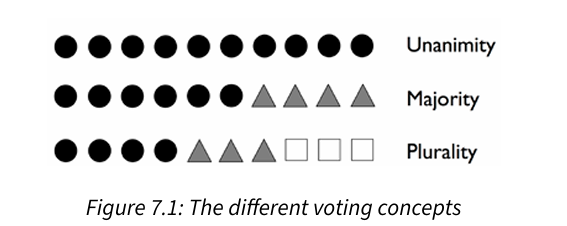

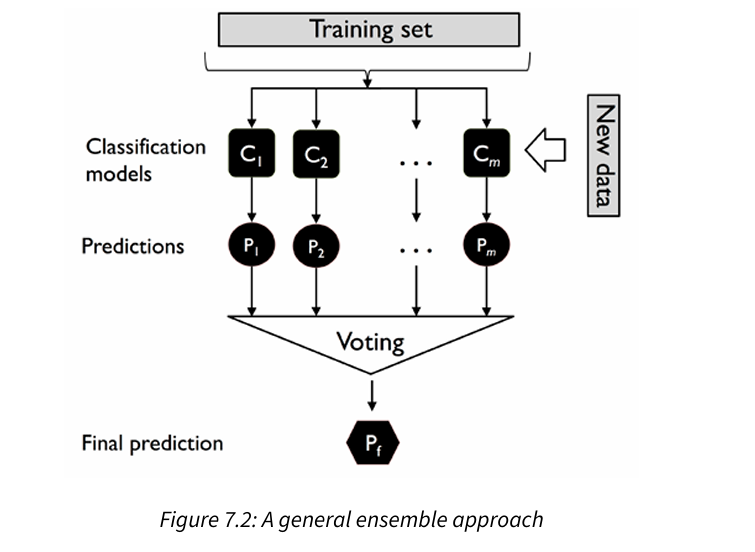

Veamos por que los metodos de ensamble funcionan mejor que los clasificadores individuales. Supongoamos que tenemos n-base clasificadores para una tarea de clasificacion binaria que tienen la el mismo ratio de error,$\epsilon$. Asumiremos que los clasificadores son independietes y que sus errores no estan correlacionados. Bajo estas condiciones podemos expresar el error de probabildiad del ensamble como uan funcion de probabildiad dada por una binomial

$$
P(y>k) = \sum_{k}^{b}<nk>\epsilon^{k}(1-\epsilon)^{n-k}
$$

Donde $<nk>$ es el combinatirio de $n$ *elije* $k$. Basicamente estamos calculando la probabildiad de que la prediccion del ensamble este mal.

In [36]:
from scipy.special import comb
import math
def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) *
               error**k *
               (1-error)**(n_classifier - k)
               for k in range(k_start, n_classifier + 1)]
    return sum(probs)
ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

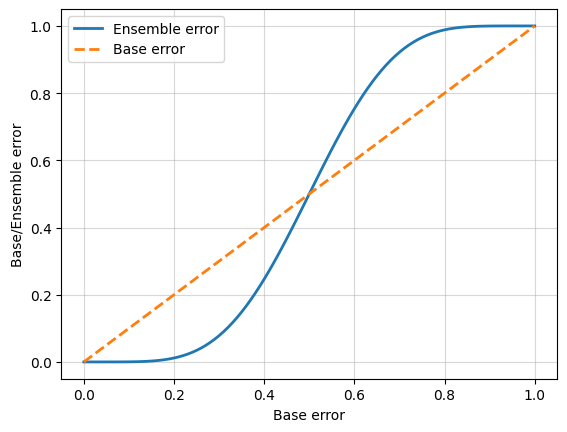

In [37]:
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
                for error in error_range]
plt.plot(error_range, ens_errors,
           label='Ensemble error',
           linewidth=2)
plt.plot(error_range, error_range,
           linestyle='--', label='Base error',
           linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

## Combining classifiers via majority vote
Luego de la introducion a ensamble learning en la seccion previa, comenzaremos con un ejerciucio de implementar un ensamble por mayoria de voto

### Implementing a simple majority vote classifier
El algoritmos que vamos a implemenar en esta seccion nos permitira combinar difrentes algortimso de clasificion asociados con pesos indifiduales para la confianza. Nuestro objetivo es contruir un meta-clasificador mas fuerte que equilibre las debilidades individuales de cada clasificador en un dataset en aprticular. En terminos mas matematicos lo que podemos escribir es

$$
\hat{y} = arg max \sum_{j=1}^{m} w_{j}\chi_{A}(C_{j}(X)=1)
$$

donde $w_j$ es le peso asociado con el clasificador base $C_j$; $\hat{y}$ es la prediccion realizada por el ensamble, A es el set unico de clases , $chi_{A}$ es la funcion caracteristica o funcion indicador que devuelve 1 si la preddiocn de la clase del j esimo clasificador matche $i$.

Para trasladar este concepto a python, podemos usar la funcion de Numpy *argmax* y *bincount*.

In [38]:
import numpy as np
np.argmax(np.bincount([0, 0, 1],
                      weights=[0.2, 0.2, 0.6]))

1

Como aprendimos en el capitulo 3, algunos algoritmos como la regresion logistica ademas de regresar la clasificacion tambien devuelven la probabilidd asociada con dicha clasificacion. Usando la prediccion de probabilidad de clase podemos modificar el algoritmos de majority vote de la siguiente manera

$$
\hat{y} = arg max \sum_j^{m} w_j p_{ij}
$$


In [39]:
ex = np.array([[0.9, 0.1],[0.8, 0.2],[0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [40]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote = 'classlabel', weights=None ):

        self.classifiers  = classifiers
        self.named_classifiers = {
            key: value for key,
            value in _name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability "
                             f"or 'classlabel'"
                             f"; got (vote)={self.vote}")
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and'
                                f' weights must be equal'
                                f'; got {len(self.weights)} weights,'
                                f' {len(self.classifiers)} classifiers')
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=  self.weights)),axis=1, arr=predictions)

        maj_vote = self.labenc_.inverse_transfor(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
            for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0,
                                        weights=self.weights)
        return avg_proba
    def get_params(self, deep=True):
            if not deep:
                return super().get_params(deep=False)
            else:
                out = self.named_classifiers.copy()
                for name, step in self.named_classifiers.items():
                    for key, value in step.get_params(
                                    deep=True).items():
                                out[f'{name}__{key}'] = value
            return out


### Using the majority voting principle to make predictions

In [41]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.5, random_state=1,stratify=y)

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2',
                           C=0.001,
                           solver='lbfgs',
                           random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                               criterion='entropy',
                               random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                             p=2,
                             metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()],
                   ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                   ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train,y=y_train,cv=10, scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
    f'(+/- {scores.std():.2f}) [{label}]')

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [43]:
# Ahora vamos ahora a aplicar la mayoria de voto
mv_clf = MajorityVoteClassifier(classifiers=[pipe1,clf2,pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
      scores = cross_val_score(estimator=clf,
                               X=X_train,
                               y=y_train,
                               cv=10,
                               scoring='roc_auc')
      print(f'ROC AUC: {scores.mean():.2f} '
            f'(+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


## Bagging - building an ensemble of classifiers from bootstrap samples
Bagging en una tecnica de ensamble que esta muy relacionada al voto de la mayoria que implementamos en la seccion anterior. Sin embargo, en vez de usar el mismo dataset de entramiento para ajustar los clasificadores de manera individual, tomamos bootsrap samples del dataset de entrenamiento inicial.

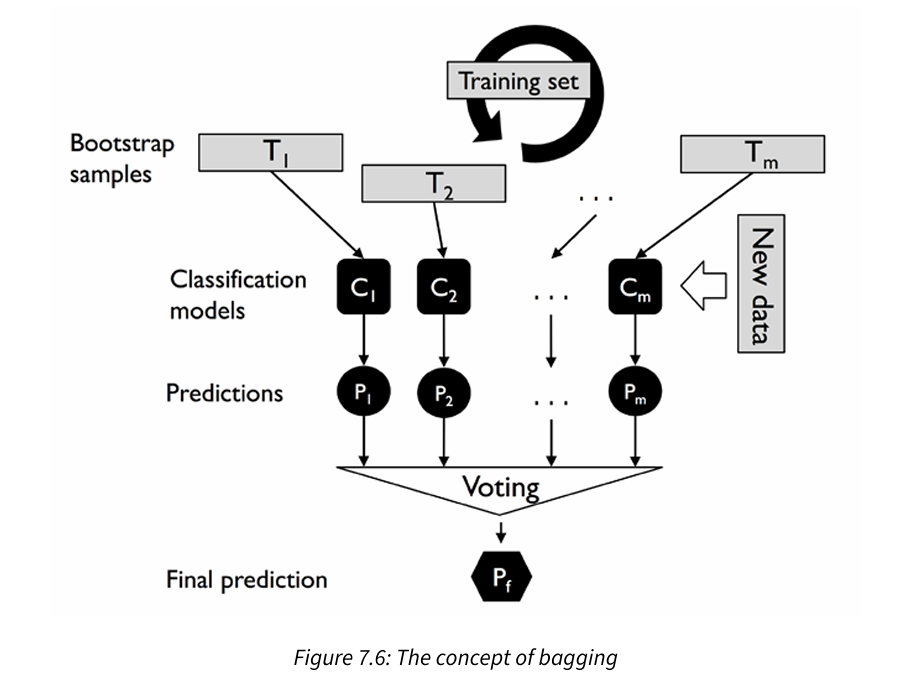

### Baggin in a nutshell
Veamos un ejemplo explicito de como funciona el bagging

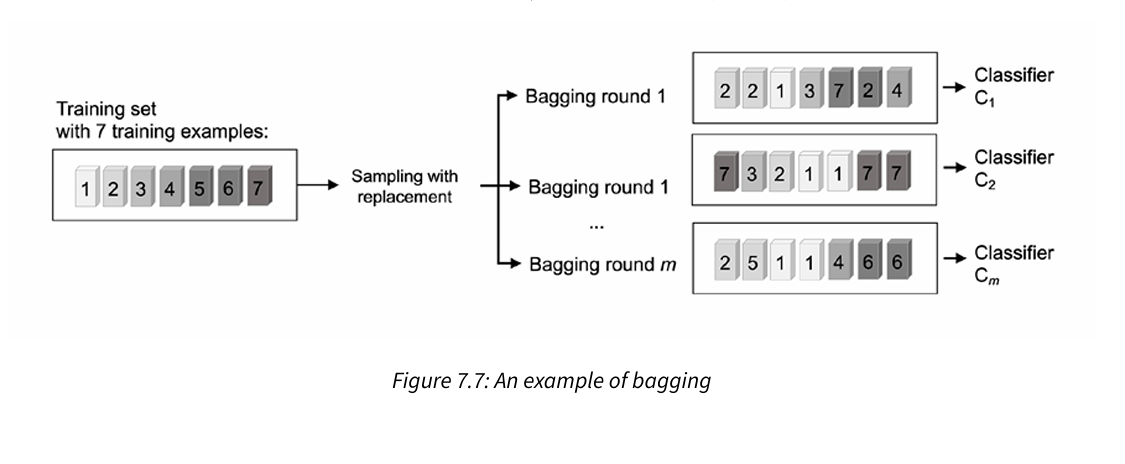


### Applying baggin to classify exampes in the Winde dataset
Para ver como actua el baggin, creemos un problema de clasificacion mas comlejo usando el datset de vinos.

In [44]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                       'machine-learning-databases/'
                       'wine/wine.data',
                       header=None)

df_wine.columns = ['Class label', 'Alcohol',
                     'Malic acid', 'Ash',
                     'Alcalinity of ash',
                     'Magnesium', 'Total phenols',
                     'Flavanoids', 'Nonflavanoid phenols',
                     'Proanthocyanins',
                     'Color intensity', 'Hue',
                     'OD280/OD315 of diluted wines',
                     'Proline']
  # drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol',
               'OD280/OD315 of diluted wines']].values

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [46]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy', random_state='1',max_depth=1)
bag = BaggingClassifier(estimator=tree,n_estimators = 500, max_samples=1.0,max_features = 1.0,bootstrap = True,bootstrap_features=False, n_jobs=1,random_state=1)

In [47]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
        f'{tree_train:.3f}/{tree_test:.3f}')


InvalidParameterError: The 'random_state' parameter of DecisionTreeClassifier must be an int in the range [0, 4294967295], an instance of 'numpy.random.mtrand.RandomState' or None. Got '1' instead.

In [34]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

## Leveraging weak learners via adaptive boosting.
En esta seccion aprenderemos sobre metodos de ensamble, discutiremos sobre el **boosting** con un especial foco en la implemementacion mas comun: **Adaptative Boosting (AdaBoost)**.

En boosting, el ensamble consiste de clasificadores base muy sencillo, comunmente referenciados como **weak learners**, los cuales son solo un poco mejor que adivinar. El concepto clave del boosting es en concentrarse en ejemplos de entrenamineto que sean dificiles de clasificar, esto es, que los alumnos debiles aprendan subsequentemente de ejemplos al clasificados para asi mejorar el perfomance.

### How adaptative boosting works
En contraste con baggin, la formulacion inicla del boosting usa un subset random del dataset de entramineto tomadas sin remplazo, el proceso puede resumirse como:

 1. Draw a random subset (sample) of training examples, d1, without replacement from the training dataset, D, to train a weak learner, C1.
 2. Draw a second random training subset, d2, without replacement from the training dataset and add 50 percent of the examples that were previously misclassified to train a weak learner, C2
  3. Find the training examples, d3, in the training dataset, D, which C1 and C2 disagree upon, to train a third weak learner, C3.
 4. Combine the weak learners C1, C2, and C3 via majority voting.


 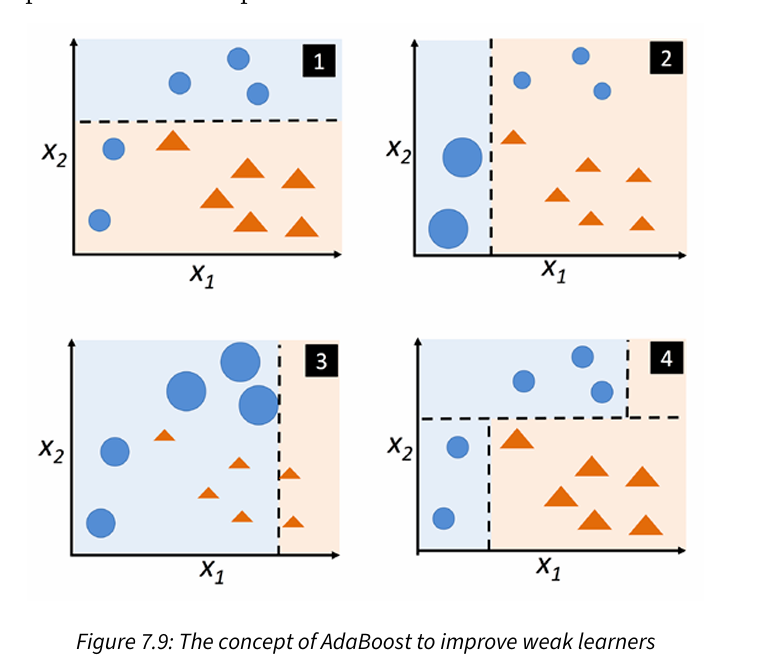

 

### Applying AdaBoost using scikit-learn

In [48]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=1)
ada = AdaBoostClassifier(estimator= tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=1)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
        f'{tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies 0.916/0.875


In [49]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print(f'AdaBoost train/test accuracies '
        f'{ada_train:.3f}/{ada_test:.3f}')

c:\Users\ivanl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost train/test accuracies 1.000/0.917


## Gradient boosting - training an ensemble based on loss gradients.
Boost de gradiente es otra varainte del concepto del boosting introducida en la seccion anterior, esto es, entranar varios weak learners para crear un ensamble fuerte. Gradiant boosting is an extremely important topic porque forma parte de algoritmos de ML muy populares como XGBoost.

El algoritmo de boost de gradiente puede parecer desmoralizador al principio. Asi que en las proximas subsecciones lo cubriremos paso por paso.

### Comparing Adaboost with gradient boosting
Fundamentalmente, gradient boosting es muy parecido a AdaBoost. Adaboost entrena arboles de decicion basado en los errores de los arboles anteriores. En particualr, el error se usa para computar un peso unicoi para cada ronda. Dejamos de entrenarlo una vez que se alcanza el numero maximo de iteraciones. COmo AdaBoost, boosteo de gradiente fitea arboles de desicion de una manera iterativa y tienen profundidad maxima varaible de entre 3 a 6. Ademas, al contrario que AdaBoost, gradient boost no usa el error de prediccion para asignar pesos, se usan de manera directa en la forma de target variable para fittear el siguiente arbol.

### Outlining the general gradient boosting algorithm

1. Comienza un modelo que retorne una constante de prediccion. Para esto, usaremos el nodo raiz de un arbol de desicion. Llamamos el valor retornado por este arbol como $\hat{y}$, y hallaremos este valor minimizando una funcion difrenciable de perdida L que definiremos despues

$$
 F_0(X)=arg min \sum_{i=1}^{n} L(y_i,\hat{y})
$$

2. Para cada arbol $m=1,...,M$, donde $M$ es el numero especifico de arboles, realizamos la siguiente cuenta:

    a. Compute the difference between a predicted value $F(X_i)=\hat{y}$  and the class label yi. This value is sometimes called the pseudo-response or pseudo-residual. More formally, we can write this pseudo-residual as the negative gradient of the loss function with respect to  the predicted values: $$ r_{im} = -[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}]$$
    Notar que en la notacion de arriba $F(x)$ es la prediccion del arbol anterior. Asi que en la primer ronda, se refiere a la constante del paso 1
    
    b. Fit a tree to the pseudo-residuals $r_im$. We use the notation Rjm to denote the j = 1 ... Jm leaf nodes of the resulting tree in iteration m.


### Explaining the gradient boosting alhorithm for classification
En esta subseccion, cubriremos los detalles de la implemtancion del gradient boosting para clasificacion binaria. En este contexto, usaremos la funcion de perdida logistica. para un solo ejemplo de entrenamiento, podemos especificar la perdida como:

$$
L_i = -y_i \log p_i + (1-y_i) \log (1-p_i)
$$

en el capitulo 3 tambien introdujimos log(prob):

$$
\log(\frac{p}{1-p})
$$

usando esto re escribiremos la funcion logistica como:

$$
L_i = \log (1+e^{\hat{y}_i})-y_i \hat{y}_i
$$

Lo que nos deja definir la dereivad parcial de la funcion de perdida con respecto a estas log(prob).

$$
\frac{\partial L_i}{\partial \hat{y}_i} =\frac{e^{\hat{y}_i}}{1+e^{\hat{y}_i}} - y_i = p_i -y_i
$$

Ahora que modificamos la definicion matematica, revisitemos los pasos del gradient boost para el caso de clasificacion binaria

1. Create a root node that minimizes the logistic loss. It turns out that the loss is minimized if the root node returns the log(odds)
2. For each tree $m=1,...,M$, where $M$ is a user-specified number of total trees, we carry out the following computations:
    
    a. We convert the log(odds) into a probability using the familiar logistic function that we used in logistic regression
    Then, we compute the pseudo-residual, which is the negative partial derivative of the loss with respect to the log(odds), which turns out to be the difference between the class label and the predicted probabilit
    
    b. Fit a new tree to the pseudo-residuals.

    c. For each leaf node $R_{jm}$, compute a value $\gamma_{jm} that minimizes the logistic loss function. This includes a summarization step for dealing with leaf nodes that contains multiple training exampes
    $$
    \gamma_{jr} = arg min \sum L(y_i,F_{m-1}(x_i)+y) = \log(1+e^{\hat{y_i}+\gamma})-y_i (\hat{y_i}+\gamma)
    $$
    Esto resulta en:
    $$
    \gamma_{jm} = \frac{\sum_i y_i-p_i}{\sum_i p_i (i-p_i)}
    $$
    Notar que la suma es solo sobre los ejemplos en el nodo correspondiente al nodo de la hoja $R_{jm}$ y no sobre todo el training set.

    d. Update the model by adding the gamma value for step 2c with learning rate $\eta$:


### Using XGBooost
Luego de cubrir todos lso detalles detras de gradient boost, veamos finalmente como usasrlo implemetnado codigo.

En scikit-learn, gradient boosting es implementado a travez de *sklear.ensemble.GradientBoostingClassifier*. Es importante notar que el gradient boost es un procedso secuancial por lo que puede ser lento de entrenar. Sin embargo en los ultimos años ha aparecido una implemetnacion mas popular, XGBoost.



In [ ]:
!pip install xgboost

In [51]:
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators = 1000, learning_rate=0.1, max_depth=4,random_state=1, use_label_encoder= False)

gbm = model.fit(X_train,y_train)
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

gbm_train = accuracy_score(y_train, y_train_pred)
gbm_test = accuracy_score(y_test, y_test_pred)
print(f'XGboost train/test accuracies '
        f'{gbm_train:.3f}/{gbm_test:.3f}')

AttributeError: module 'xgboost' has no attribute 'XGBC'